# Calculate sound propagation

1. We calculate distance between two furthest recording points.
2. Then use speed of sound in this conditions to calculate travel time

For speed of sound, followed this webpage: http://resource.npl.co.uk/acoustics/techguides/soundseawater/. Used water temp = 28C, Salinity = 33.58 (taken from Rosalina et al., 2024 for the month of July in Spermonde in 2022*), Depth = 17m, Latitude = -4° 55' 47.712". Using the Mackenzie equation this gives 1541.007 m/s.

The study sites can be found here: https://www.google.com/maps/d/edit?mid=1etfYnjSsrtYnjrdnpzZR62knsrIj1t4&usp=sharing 


*SALINITY DISTRIBUTION PATTERN IN SPERMONDE WATERS USING REMOTE SENSING DATA (COPERNICUS MARINE SERVICE) IN 2022. (Google 'Spermonde salinity' to find this).

In [1]:
# Calc distance and travel time at 1541.007 m/s
# !pip install geopy

from geopy.distance import geodesic

# Recording-site coords
coord_a = (-4.70878, 119.32657)   # M35 Samatellu
coord_b = (-5.07711, 119.31749)   # M43 Barrang Caddi

speed_m_s = 1541.007  # speed in metres per second

# Distance
distance_km = geodesic(coord_a, coord_b).kilometers
distance_halved = distance_km / 2
distance_m = distance_km * 1000


# Travel time
travel_time_s = distance_m / speed_m_s
travel_time_halved_s = distance_halved * 1000 / speed_m_s

print(f"Distance: {distance_km:.3f} km")
print(f"Travel time at {speed_m_s} m/s: {travel_time_s:.3f} s")
print(f"Distance halved: {distance_halved:.3f} km")

Distance: 40.743 km
Travel time at 1541.007 m/s: 26.439 s
Distance halved: 20.372 km


# Calculate windows to check
This code reports possible detections of the same blast event if we use a reasonable time window for which we should check if blasts co-occur at the same time in different recorders.

To calc the reasonable window:
1. We used Hydromoths, for which Open Acoustics expect **clock drift** to be around 0.25sec per day: https://www.openacousticdevices.info/support/device-support/question-about-timing/dl-focus. We recorded on four unique days, so worst case scenario if one recorder drifted one way and another the opposite, that gives a 2sec misalignment. So, if a bomb was heard at the northern or southern most recorder, it would take 26.439 +- 2 second to reach the opposite recorder which is 28.439 sec maximum.
3. However, the **bomb model does not work on exact start timestamps for bombs**, it uses windows 2.88sec in length. So in theory, a timestamp given for a bomb may be 2.88sec earlier than the actual bomb (of course it would likely be less, but we take this maximum to be conservative). So we add this to get **31.319sec**.

In [2]:
# This cell loads bomb detection CSVs, computes full event timestamps,
# clusters events that fall within a defined time window,
# and prints out groups detected simultaneously across multiple recorders.

import os
import pandas as pd
from dataclasses import dataclass
from datetime import datetime, timedelta
from pathlib import Path
from typing import List

# Base directory from environment
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
    raise ValueError("BASE_DIR must be set")
INPUT_PATH = Path(os.path.join(BASE_DIR, "bomb_fishing/data"))

# Maximum allowable difference between events to consider co-occurring
TIME_WINDOW_S: float = 31.319
window_delta: timedelta = timedelta(seconds=TIME_WINDOW_S)

@dataclass
class BombEvent:
    """
    Represents a single bomb detection event.

    Attributes:
        csv: Name of the CSV file where event was recorded
        file: WAV filename containing the timestamp reference
        timestamp: String HH:MM:SS offset into the WAV file
        when: Absolute datetime of the event
    """
    csv: str
    file: str
    timestamp: str
    when: datetime


def load_events(input_dir: Path) -> List[BombEvent]:
    """
    Load bomb events marked 'y' from CSVs, compute absolute timestamps.

    Returns list of BombEvent.
    """
    events: List[BombEvent] = []
    for csv_file in sorted(input_dir.glob("*.csv")):
        df = pd.read_csv(csv_file)
        df = df[df["Bomb"] == "y"].copy()
        if df.empty:
            continue
        # parse base datetime from filename prefix
        df["base_dt"] = (
            df["File"]
            .str.extract(r"(\d{8}_\d{6})")[0]
            .apply(lambda s: datetime.strptime(s, "%Y%m%d_%H%M%S"))
        )
        # get offset and compute absolute time
        df["offset"] = pd.to_timedelta(df["Timestamp (HH:MM:SS)"])
        df["when"] = df["base_dt"] + df["offset"]
        for row in df.itertuples():
            events.append(
                BombEvent(
                    csv=csv_file.name,
                    file=row.File,
                    timestamp=row._2,
                    when=row.when,
                )
            )
    return events


def cluster_events(events: List[BombEvent]) -> List[List[BombEvent]]:
    """
    Slide a window across sorted events, grouping events within window_delta.
    Picks the earliest event per CSV in each window and deduplicates clusters.
    """
    sorted_events = sorted(events, key=lambda e: e.when)
    clusters: List[List[BombEvent]] = []
    seen = set()
    start = 0
    for end, evt in enumerate(sorted_events):
        # advance start so window fits within time delta
        while sorted_events[end].when - sorted_events[start].when > window_delta:
            start += 1
        window = sorted_events[start:end+1]
        # select earliest event per CSV
        per_csv = {}
        for e in window:
            per_csv.setdefault(e.csv, e)
        if len(per_csv) >= 2:
            # build cluster sorted by time
            cluster = sorted(per_csv.values(), key=lambda x: x.when)
            # dedupe based on csv names and times
            key = tuple((e.csv, e.when.isoformat()) for e in cluster)
            if key not in seen:
                seen.add(key)
                clusters.append(cluster)
    return clusters


def print_clusters(clusters: List[List[BombEvent]]) -> None:
    """
    Print clusters by descending number of distinct CSV sources.
    """
    buckets = {4: [], 3: [], 2: []}
    for grp in clusters:
        count = len(grp)
        if count in buckets:
            buckets[count].append(grp)
    for count in (4, 3, 2):
        if not buckets[count]:
            continue
        print(f"\nEvents in {count} files:")
        for grp in buckets[count]:
            for e in grp:
                print(f"- {e.csv}: File={e.file}, Timestamp={e.timestamp}")
            print("---")

# Load and cluster events
events = load_events(INPUT_PATH)
if not events:
    print("No bomb events found in the directory.")
else:
    clusters = cluster_events(events)
    if clusters:
        print_clusters(clusters)
    else:
        print(f"No co-occurring events within {TIME_WINDOW_S} seconds.")


Events in 3 files:
- A_M35.csv: File=20240701_141200.WAV, Timestamp=00:00:14
- C_M41.csv: File=20240701_141200.WAV, Timestamp=00:00:14
- D_M43.csv: File=20240701_141200.WAV, Timestamp=00:00:25
---
- B_M36.csv: File=20240701_232301.wav, Timestamp=00:00:27
- C_M41.csv: File=20240701_232300.WAV, Timestamp=00:00:30
- A_M35.csv: File=20240701_232300.WAV, Timestamp=00:00:36
---
- B_M36.csv: File=20240702_002802.wav, Timestamp=00:00:31
- C_M41.csv: File=20240702_002800.WAV, Timestamp=00:00:34
- A_M35.csv: File=20240702_002800.WAV, Timestamp=00:00:38
---
- B_M36.csv: File=20240702_094501.wav, Timestamp=00:00:02
- C_M41.csv: File=20240702_094500.WAV, Timestamp=00:00:10
- D_M43.csv: File=20240702_094500.WAV, Timestamp=00:00:21
---
- B_M36.csv: File=20240702_111402.wav, Timestamp=00:00:00
- A_M35.csv: File=20240702_111401.WAV, Timestamp=00:00:04
- C_M41.csv: File=20240702_111400.WAV, Timestamp=00:00:08
---
- C_M41.csv: File=20240702_125900.WAV, Timestamp=00:00:00
- B_M36.csv: File=20240702_12590

# Stats test
After checking the spectrograms, nine blast events were found which appear to have been detected by 3 different recorders within the same window. However, we need to check the probability this could happen by chance.

C M43, Bontosua, had the shortest recording time at 20240701_101100 to 20240704_104400. So we can use this as the most conservative (i.e)..

We run a permutation 'Monte-carlo' test to find the chances these 9 events would co-occur given the total time by:
- Randomly reassign each detection timestamp to a new location
    within the full recording window [0, T] (in seconds).
- Repeat this process `n_sims` times.
- For each shuffle, count how many events in array A have a
    corresponding event in both B and C within ± window seconds. 
    Which is still 31.319 and hence very conservative as it allows bombs to occur up to 62.6sec apart.
- Finally, return the proportion of shuffles that produced 9 or more
    triple-overlapping events.

In [3]:
import numpy as np

# Define recording window bounds explicitly
start_dt = datetime.strptime("20240701_101100", "%Y%m%d_%H%M%S")
end_dt = datetime.strptime("20240704_104400", "%Y%m%d_%H%M%S")
T = (end_dt - start_dt).total_seconds()

# Identify the three overlapping recorders (CSV names)
overlap_csvs = sorted({e.csv for grp in clusters for e in grp})[:3] #['A_M35.csv', 'B_M36.csv', 'C_M41.csv'] <- the 3 recorders of interest

# Extract detection times (seconds from start) for each. Start by looping through the csvs, finding
# all blast events for each, saving as a np array of seconds since overall start time (start_dt). 
arrays = {
    name: np.array([(evt.when - start_dt).total_seconds() for evt in events if evt.csv == name])
    for name in overlap_csvs
}
# Should give us 3 arrays, one for each of the 3 recorders
if len(arrays) < 3:
    raise RuntimeError("Need three overlapping recorders for Monte Carlo test.")

# Extract the arrays of times for each of the three recorders
tA, tB, tC = (arrays[overlap_csvs[i]] for i in range(3))

# Run permutations
def monte_carlo_pvalue(arrays: List[np.ndarray], window: float, T: float, n_sims: int = 10000) -> float:
    """
    Estimate the probability of observing at least 9 co-occurring events
    across three recorders by chance alone, using random shuffling.

    Args:
        arrays: List of three NumPy arrays [A, B, C], each containing
                detection times in seconds from a common start time.
        window: Float time window (in seconds) for considering co-occurrences.
        T:      Total recording duration (in seconds).
        n_sims: Number of random shuffles (default 10 000).

    Returns:
        Estimated p-value (float) for observing ≥9 triple-overlaps.
    """
    A, B, C = arrays
    count = 0
    for _ in range(n_sims):
        # Randomly redistribute each array's detections uniformly over [0, T]
        sA = np.random.rand(len(A)) * T
        sB = np.random.rand(len(B)) * T
        sC = np.random.rand(len(C)) * T

        # Count how many events in A have nearby events in both B and C
        cnt = sum(
            1 for x in sA
            if (np.any(np.abs(sB - x) <= window)
                and np.any(np.abs(sC - x) <= window))
        )
        if cnt >= 9:
            count += 1

    return count / n_sims

p_val = monte_carlo_pvalue([tA, tB, tC], TIME_WINDOW_S, T)
print(f"Monte Carlo p-value ≈ {p_val:.4f}")

# Note, a good sanity check its working correctly is to change end_dt to be much earlier, which gives a high p-value.


Monte Carlo p-value ≈ 0.0000


# Plots

### WARNING: The below is vibe coded so do not use yet

1. Given we only found co-occurances in 3 recorders (A,B,C) we now calculate the distance between these. 
2. We therefore get a range estimate as to how far we can hear bombs. The absolute minimum is the halfway point between these two recorders.
3. However, it may be much further as bombing could be predominantly happening further away

In [4]:
# Calc distance and travel time at 1541.007 m/s

from geopy.distance import geodesic

# Recording-site coords
coord_a = (-4.70878, 119.32657)   # M35 Samatellu
coord_c = (-4.92992, 119.31595)   # M43 Bontosua

speed_m_s = 1541.007  # speed in metres per second from earier

# Distance
distance_km = geodesic(coord_a, coord_c).kilometers
distance_halved = distance_km / 2
distance_m = distance_km * 1000


# Travel time
travel_time_s = distance_m / speed_m_s
travel_time_halved_s = distance_halved * 1000 / speed_m_s

print(f"Distance between A & C: {distance_km:.3f} km")
print(f"Minimum distance over which bombs can be heard: {distance_halved:.3f} km")

Distance between A & C: 24.482 km
Minimum distance over which bombs can be heard: 12.241 km


In [5]:
# Define recorder locations and timestampes of detections for next cell
from typing import List, Tuple

# Recorder positions (latitude, longitude)
a_coords_geo: List[Tuple[float, float]] = [
    (-4.70878, 119.32657),  # A
    (-4.80363, 119.32858),  # B
    (-4.92992, 119.31595),  # C
]


# Time sets for 8 detections
time_sets: List[List[datetime]] = [
    [datetime(2024,7,1,23,23,37), # Recorder A
     datetime(2024,7,1,23,23,31), # Recorder B
     datetime(2024,7,1,23,23,32)], # Recorder C

    [datetime(2024,7,2,0,28,41,400000), 
     datetime(2024,7,2,0,28,35,200000), 
     datetime(2024,7,2,0,28,38,500000)],

    [datetime(2024,7,2,11,14,6,600000), 
     datetime(2024,7,2,11,14,2,800000), 
     datetime(2024,7,2,11,14,11,100000)],

    [datetime(2024,7,2,13,41,37,200000), 
     datetime(2024,7,2,13,41,31,800000), 
     datetime(2024,7,2,13,41,38,100000)],

    [datetime(2024,7,3,14,59,31,800000), 
     datetime(2024,7,3,14,59,26,900000), 
     datetime(2024,7,3,14,59,30,700000)],

    [datetime(2024,7,3,15,16,28,800000), 
     datetime(2024,7,3,15,16,23,900000), 
     datetime(2024,7,3,15,16,27,600000)],

    [datetime(2024,7,3,17,38,25,800000), 
     datetime(2024,7,3,17,38,21),      
     datetime(2024,7,3,17,38,23,600000)],

    [datetime(2024,7,4,4,49,32),       
     datetime(2024,7,4,4,49,27,700000),    
     datetime(2024,7,4,4,49,31)]
]

In [ ]:
# Inputs: geographic coords (lat, lon) and detection times
a_coords_geo: List[Tuple[float, float]] = [
    (-4.70878, 119.32657), # A
    (-4.80363, 119.32858), # B
    (-4.92992, 119.31595), # C
]
times: List[datetime] = [
    datetime(2024, 7, 1, 23, 23, 37),  # A
    datetime(2024, 7, 1, 23, 23, 31),  # B
    datetime(2024, 7, 1, 23, 23, 32),  # C
]


In [12]:
# CELL 1: Hyperbolic triangulation in local Cartesian coordinates

import numpy as np
from datetime import datetime
from typing import List, Tuple
from scipy.optimize import least_squares

# Constants
c: float = speed_m_s # sound speed in water (m/s)
MAX_DRIFT_S: float = 1.0 # max clock drift per recorder (s)
EARTH_R: float = 6_378_137  # Earth radius (m) at equator: https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html

# Inputs: geographic coords (lat, lon) and detection times
a_coords_geo: List[Tuple[float, float]] = [
    (-4.70878, 119.32657), # A
    (-4.80363, 119.32858), # B
    (-4.92992, 119.31595), # C
]
times: List[datetime] = [
    datetime(2024, 7, 1, 23, 23, 37),  # A
    datetime(2024, 7, 1, 23, 23, 31),  # B
    datetime(2024, 7, 1, 23, 23, 32),  # C
]

# Reference origin for projection (mean lat/lon)
ref_lat = np.mean([lat for lat, _ in a_coords_geo])
ref_lon = np.mean([lon for _, lon in a_coords_geo])

# Precompute degree-to-metre factors at ref latitude
factor_x = EARTH_R * np.cos(np.deg2rad(ref_lat)) * np.deg2rad(1)
factor_y = EARTH_R * np.deg2rad(1)

# Convert geographic coords to local Cartesian (metres)
coords: List[Tuple[float, float]] = [
    ((lon - ref_lon) * factor_x,
     (lat - ref_lat) * factor_y)
    for lat, lon in a_coords_geo
]

# Residuals for Time Difference of Arrival (TDOA) localisation,
# modelling clock drift as additional unknowns.
def hyperbola_residuals(
    vars: np.ndarray,
    coords: List[Tuple[float, float]],
    times: List[datetime],
    c: float,
    max_drift: float
) -> np.ndarray:
    """
    Compute residuals for two TDOA-based hyperbola equations with clock drift correction.

    We model the unknowns as:
      vars = [x, y, ε1, ε2, ε3]
    where (x,y) is the source position in local Cartesian (metres),
    and εi is a small clock offset (seconds) for recorder i.

    For each recorder j (=B,C), we enforce:
      (distance from (x,y) to recorder_j) - (distance to recorder_A)
        = c * [(t_j + εj) - (t_A + ε1)]
    residual = left - right

    Args:
        vars:      length-5 vector of [x, y, ε1, ε2, ε3]
        coords:    list of three (x,y) recorder positions (metres)
        times:     list of three datetime detection times (UTC)
        c:         sound speed in water (m/s)
        max_drift: max allowed |εi| (seconds) to constrain drift

    Returns:
        length-2 array of residuals [res_BA, res_CA],
        large values if drift exceeds max_drift to steer solver away.
    """
    # Unpack source coords and per-recorder drifts
    x, y, e1, e2, e3 = vars
    drifts = np.array([e1, e2, e3])
    # Penalise solutions with excessive clock drift
    if np.any(np.abs(drifts) > max_drift):
        # Return huge residuals so solver rejects this region as it violates the 1sec clock drift rule
        return np.full(2, 1e6)

    # Reference time at recorder A (with drift)
    t0 = times[0].timestamp() + e1
    residuals = []
    # Build one residual per additional recorder (B then C)
    for j, (xj, yj) in enumerate(coords[1:], start=1):
        # Arrival time at recorder j with drift
        tj = times[j].timestamp() + drifts[j]
        # Euclidean distances from source guess to recorder j and A
        d_j = np.hypot(x - xj, y - yj)
        d_1 = np.hypot(x - coords[0][0], y - coords[0][1])
        # Residual: geometric minus acoustic-predicted range difference
        # so model pred - ground truth observation. This tells us how far off
        # the guess of (x,y,ε’s) is from matching the recorded time‐differences.
        residuals.append(d_j - d_1 - c * (tj - t0))
    # Return residuals
    return np.array(residuals)

# ** Batch solve all time‐sets and print results **
# Solve for source location and clock drifts using least-squares
# It runs an iterative algorithm to find the best fit for the hyperbola equations.
# It starts with guess: an initial vector of zeros for [x, y, ε1, ε2, ε3]. 
# On each iteration it calls hyperbola_residuals() to get the current residuals, then
# estimates how small tweaks to vars will affect the residuals. Then updates guess
# accordingly. It continues until the residuals are small enough or it reaches a max 
# number of iterations.
initial_guess = np.zeros(5) # we start with 0's for each of the 5 parameters

# Loop pver each set of detection times
for idx, times in enumerate(time_sets, start=1):
    # Run our optimiser using least squares
    sol = least_squares(
        hyperbola_residuals,
        initial_guess, # Used as the vars arg in the hyperbola_residuals function call. This gets updated each call.
        args=(coords, times, c, MAX_DRIFT_S)
    )
    # The outputs form least sqaures can be found in sol.x
    x_est, y_est, e1, e2, e3 = sol.x

    # Convert solution back to geographic coordinates
    lat_i = ref_lat + (y_est / factor_y)
    lon_i = ref_lon + (x_est / factor_x)

    # Compute hearing radius in km
    radius_i = max(np.hypot(x_est - xi, y_est - yi) for xi, yi in coords) / 1000

    # Print results for this event
    print(
        f"Event {idx}: lat={lat_i:.5f}, lon={lon_i:.5f}, "
        f"drifts=[{e1:.3f},{e2:.3f},{e3:.3f}], "
        f"radius={radius_i:.2f} km"
    )

    # Save the **last** event’s values into lat_est/lon_est/radius_km
    # so Cell 2 can plot the final one if you rerun the notebook
    lat_est = lat_i
    lon_est = lon_i
    radius_km = radius_i

Event 1: lat=-4.85431, lon=119.28102, drifts=[0.000,0.000,0.000], radius=16.97 km
Event 2: lat=-4.83874, lon=119.29637, drifts=[0.000,0.000,0.000], radius=14.85 km
Event 3: lat=-4.78701, lon=119.30548, drifts=[0.000,0.000,0.000], radius=15.95 km
Event 4: lat=-4.81181, lon=119.29715, drifts=[0.000,0.000,0.000], radius=13.31 km
Event 5: lat=-4.82532, lon=119.27129, drifts=[0.000,0.000,0.000], radius=14.35 km
Event 6: lat=-4.82606, lon=119.27048, drifts=[0.000,0.000,0.000], radius=14.46 km
Event 7: lat=-4.83384, lon=119.25909, drifts=[0.000,0.000,0.000], radius=15.81 km
Event 8: lat=-4.82425, lon=119.25493, drifts=[0.000,0.000,0.000], radius=15.11 km


### Plot hyperbola
TODO: There are two hyperbola currently, but we can get rid of one for each site combo as we know the time sounds arrived

Estimated source location: lat=-4.85431, lon=119.28102


/tmp/ipykernel_26418/734712567.py:112: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')


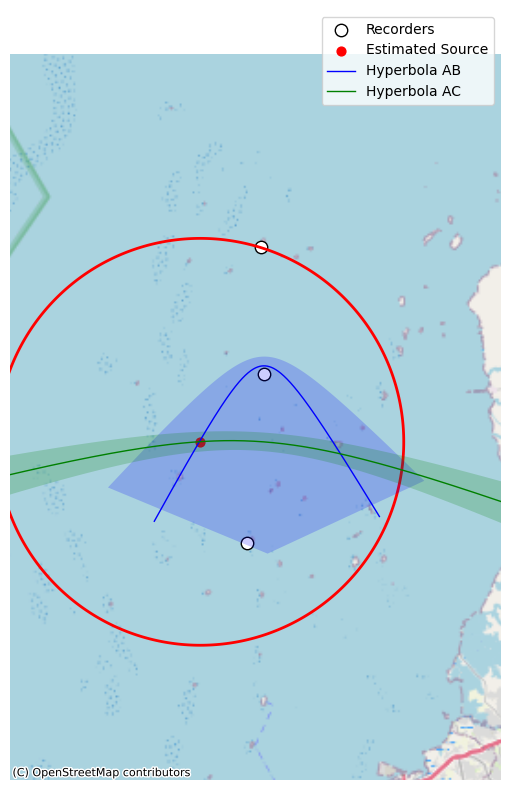

In [7]:
# CELL 2: Plot estimated source and TDOA hyperbolae with shaded clock‐drift bands

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, Polygon
from math import sqrt

# Convert recorder and source locations to Web Mercator
rec_map = gpd.GeoDataFrame(
    {'label': ['A','B','C']},
    geometry=[Point(lon, lat) for lat, lon in a_coords_geo],
    crs='EPSG:4326'
).to_crs(epsg=3857)

src_map = gpd.GeoDataFrame(
    {'label': ['Source']},
    geometry=[Point(lon_est, lat_est)],
    crs='EPSG:4326'
).to_crs(epsg=3857)

# Recorder coordinates in metres
foci = list(zip(rec_map.geometry.x, rec_map.geometry.y))

# TDOA distances in metres (with ±1s clock uncertainty)
delta21 = c * (times[1].timestamp() - times[0].timestamp())
delta31 = c * (times[2].timestamp() - times[0].timestamp())
drift_range = c  # ±1s = ±c metres

def gen_hyperbola_branches(f1: tuple, f2: tuple, delta: float, num: int = 400):
    """
    Generate both branches of a hyperbola in Web Mercator (metres),
    defined by two foci (f1, f2) and a range-difference (delta).

    Returns:
      branch_pos, branch_neg : each is an (num,2) array [x, y].
    """
    x1, y1 = f1
    x2, y2 = f2
    half_base = np.hypot(x2 - x1, y2 - y1) / 2
    a = abs(delta) / 2
    b = sqrt(max(half_base**2 - a**2, 0))
    xc, yc = (x1 + x2)/2, (y1 + y2)/2
    theta = np.arctan2(y2 - y1, x2 - x1)
    u = np.linspace(-2, 2, num)
    branches = []
    for sign in (1, -1):
        xp = sign * a * np.cosh(u)
        yp = b * np.sinh(u)
        xr = xc + xp*np.cos(theta) - yp*np.sin(theta)
        yr = yc + xp*np.sin(theta) + yp*np.cos(theta)
        branches.append(np.vstack((xr, yr)).T)
    return branches  # [branch_pos, branch_neg]

# Generate branches for AB and AC (nominal + bounds)
ab_nom, ab_alt = gen_hyperbola_branches(foci[0], foci[1], delta21)
ab_lo,  _      = gen_hyperbola_branches(foci[0], foci[1], delta21 - drift_range)
ab_hi,  _      = gen_hyperbola_branches(foci[0], foci[1], delta21 + drift_range)

ac_nom, ac_alt = gen_hyperbola_branches(foci[0], foci[2], delta31)
ac_lo,  _      = gen_hyperbola_branches(foci[0], foci[2], delta31 - drift_range)
ac_hi,  _      = gen_hyperbola_branches(foci[0], foci[2], delta31 + drift_range)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
# Recorders & source
# print estimated source coordinates
print(f"Estimated source location: lat={lat_est:.5f}, lon={lon_est:.5f}")
rec_map.plot(ax=ax, color='white', edgecolor='black', markersize=80, label='Recorders')
# plot source as red dot instead of star
src_map.plot(ax=ax, color='red', marker='o', markersize=40, label='Estimated Source')

# Hearing-radius circle
sx, sy = src_map.geometry.iloc[0].x, src_map.geometry.iloc[0].y
circle = Point(sx, sy).buffer(radius_km * 1000, resolution=100)
gpd.GeoSeries([circle], crs='EPSG:3857').plot(
    ax=ax, edgecolor='red', linewidth=2, facecolor='none',
    label=f'Radius = {radius_km:.2f} km'
)

# Shaded ±1s band for AB
poly_ab = Polygon(np.vstack((ab_lo, ab_hi[::-1])))
gpd.GeoSeries([poly_ab], crs='EPSG:3857').plot(
    ax=ax, facecolor='blue', alpha=0.2, edgecolor=None, label='±1 s AB'
)
# Nominal AB hyperbola
ax.plot(ab_nom[:,0], ab_nom[:,1], color='blue', linewidth=1, label='Hyperbola AB')

# Shaded ±1s band for AC
poly_ac = Polygon(np.vstack((ac_lo, ac_hi[::-1])))
gpd.GeoSeries([poly_ac], crs='EPSG:3857').plot(
    ax=ax, facecolor='green', alpha=0.2, edgecolor=None, label='±1 s AC'
)
# Nominal AC hyperbola
ax.plot(ac_nom[:,0], ac_nom[:,1], color='green', linewidth=1, label='Hyperbola AC')

# Basemap
try:
    provider = ctx.providers.Stamen.Terrain
except (AttributeError, KeyError):
    provider = ctx.providers.OpenStreetMap.Mapnik
ctx.add_basemap(ax, source=provider, crs='EPSG:3857')

# Zoom with buffer
xmin, ymin, xmax, ymax = rec_map.total_bounds
buf = max(xmax - xmin, ymax - ymin) * 0.8
ax.set_xlim(xmin - buf, xmax + buf)
ax.set_ylim(ymin - buf, ymax + buf)

# Legend & tidy
ax.legend(loc='upper right')
ax.set_axis_off()
plt.tight_layout()
plt.show()

TODO:
1. Check the above is implemented correctly.
2. Repeat for all triple detections (and double?)

Methods
1. Describe how we selected window to check, this check + the probability that these would occur by chance.
2. We took these detections where three recorders detected the same blasts to estimate the distance over which blasts could be heard.
3. Describe the approach above. Crucially, the aim was to estimate the distance, this does not necessarily represent the most frequently impacted sites but rather the locations where blasts could be detected by three recorders.

## Old plots

In [8]:
import logging
from pathlib import Path
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# logging
logging.basicConfig(level=logging.INFO)

# where your CSVs live
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
    raise ValueError("BASE_DIR must be set")
INPUT_DIR = Path(os.path.join(BASE_DIR, "bomb_fishing/data"))

# figure size for daily plots
FIGSIZE = (12, 4)


In [9]:
def load_and_process(csv_file: Path) -> pd.DataFrame:
    """Load CSV and return DataFrame of 'y' bomb events with full timestamps."""
    df = pd.read_csv(csv_file)
    df = df[df["Bomb"] == "y"].copy()
    if df.empty:
        return pd.DataFrame(columns=["file_id", "when"])
    # parse base datetime from filename (e.g. 20240623_200400)
    df["base_dt"] = (
        df["File"]
        .str.extract(r"(\d{8}_\d{6})")[0]
        .apply(lambda s: datetime.strptime(s, "%Y%m%d_%H%M%S"))
    )
    # add the HH:MM:SS offset
    df["offset"] = pd.to_timedelta(df["Timestamp (HH:MM:SS)"])
    df["when"] = df["base_dt"] + df["offset"]
    df["file_id"] = csv_file.stem
    return df[["file_id", "when"]]

def plot_daily_timelines(events: pd.DataFrame) -> None:
    """For each calendar day, draw a separate 24h timeline."""
    events["date"] = events["when"].dt.date
    colours = plt.cm.tab20.colors

    for day, grp in events.groupby("date"):
        fig, ax = plt.subplots(figsize=FIGSIZE)
        files = sorted(grp["file_id"].unique())
        colour_map = {f: colours[i % len(colours)] for i, f in enumerate(files)}

        for fid, sub in grp.groupby("file_id"):
            y = files.index(fid)
            ax.scatter(sub["when"], [y] * len(sub),
                       color=colour_map[fid], s=40, label=fid)
            for _, row in sub.iterrows():
                ts = row["when"].strftime("%H:%M:%S")
                ax.text(row["when"], y, ts,
                        fontsize=6, ha="center",
                        va="bottom", rotation=45)

        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        ax.set_yticks(range(len(files)))
        ax.set_yticklabels(files)
        ax.set_xlabel("Time of day")
        ax.set_ylabel("File")
        ax.set_title(f"Bomb detections on {day:%Y-%m-%d}")
        ax.legend(title="File", bbox_to_anchor=(1.05, 1),
                  loc="upper left", fontsize=6)
        fig.tight_layout()
        plt.show()


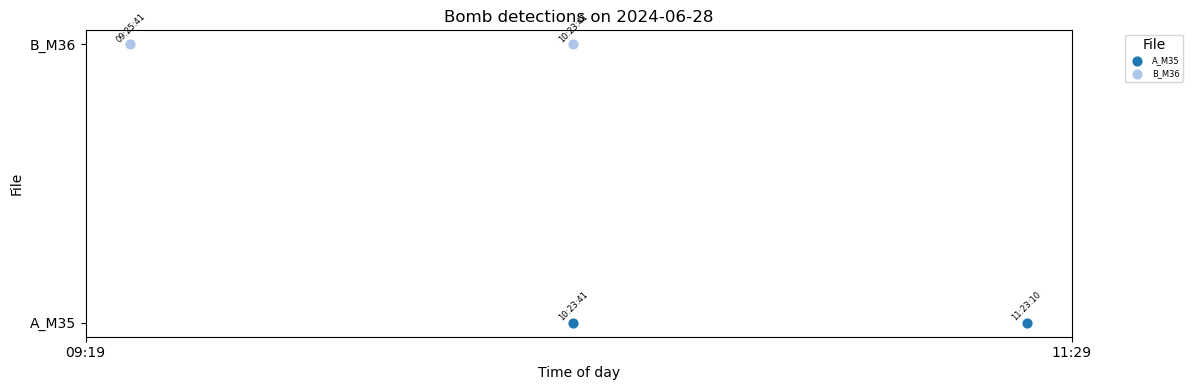

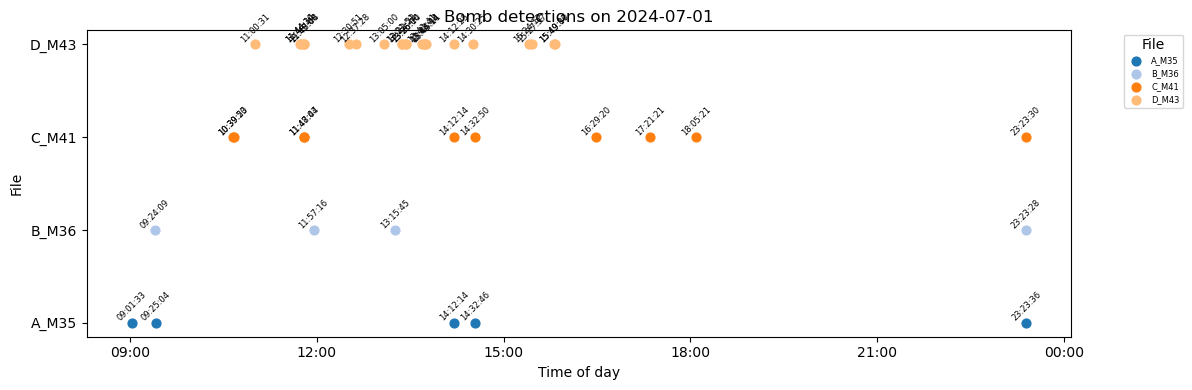

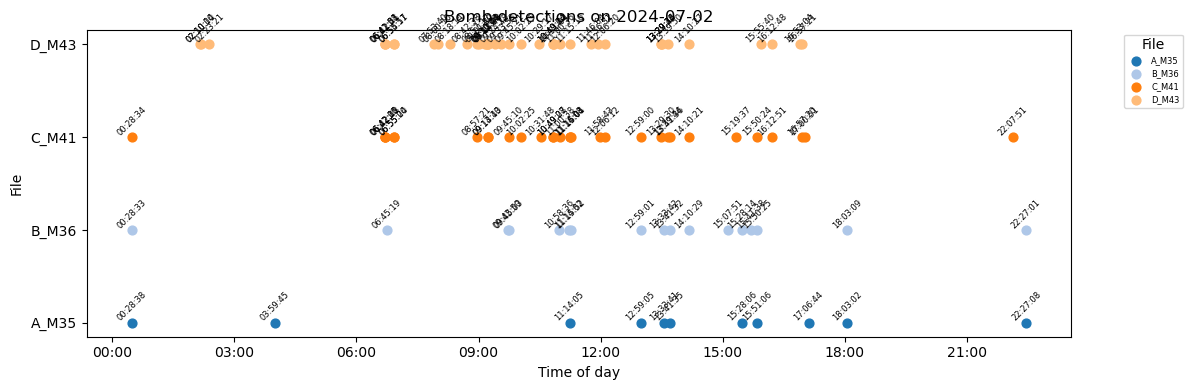

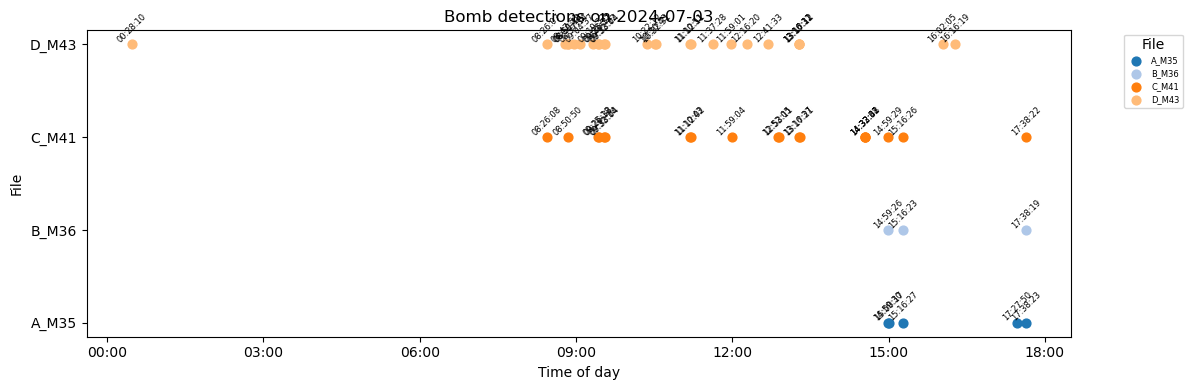

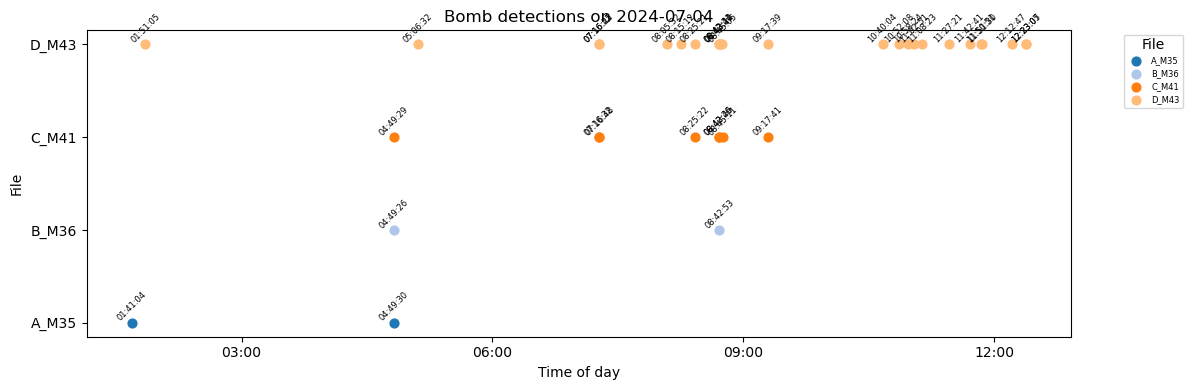

In [10]:
# collect all 'y' events
csvs = list(INPUT_DIR.glob("*.csv"))
all_events = pd.concat(
    [load_and_process(f) for f in csvs],
    ignore_index=True
)

# plot or warn
if all_events.empty:
    logging.warning("No 'y' entries found in any CSV.")
else:
    plot_daily_timelines(all_events)
